In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/Plant_1_Weather_Sensor_Data.csv')
df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [4]:
df.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
3177,2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,4135001,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0
3181,2020-06-17 23:45:00,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0


In [5]:
df.shape

(3182, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [7]:
time = pd.date_range(start='5/15/2020',periods=3182,freq='15min')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['DATE_TIME','PLANT_ID','SOURCE_KEY'],axis=1,inplace=True)
df = df.set_index('time_stamp')
df = df[['AMBIENT_TEMPERATURE']]

In [ ]:
df.head()

,AMBIENT_TEMPERATURE
time_stamp,
2020-05-15 00:00:00,25.184316
2020-05-15 00:15:00,25.084589
2020-05-15 00:30:00,24.935753
2020-05-15 00:45:00,24.846130
2020-05-15 01:00:00,24.621525


In [8]:
plt.rcParams['figure.figsize'] = [15,8]

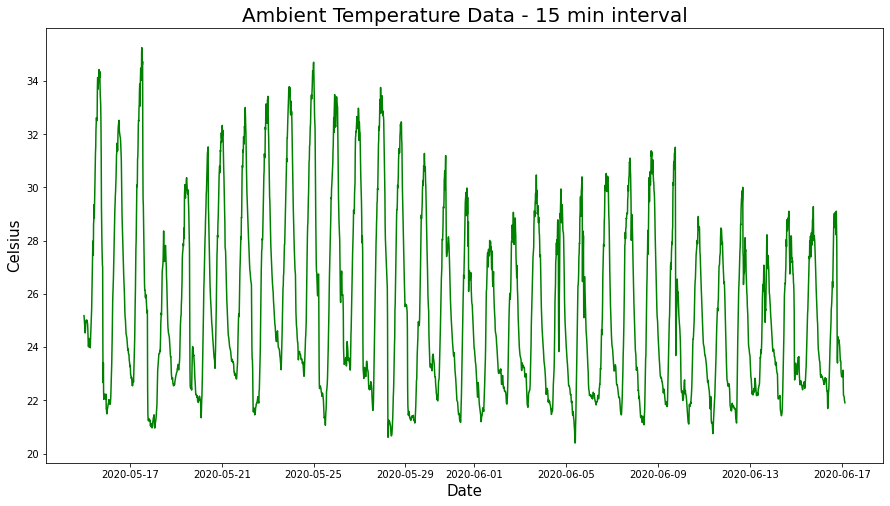

In [9]:
plt.plot(df,color='green')
plt.title('Ambient Temperature Data - 15 min interval',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Celsius',fontsize=15)
plt.show()

In [10]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [25]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['AMBIENT_TEMPERATURE'] = df['AMBIENT_TEMPERATURE'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [26]:
#Split data set into testing dataset and train dataset
train_size = 2800
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2796, 1, 4)
(2796,)
(378, 1, 4)
(378,)


In [14]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 6.8 MB/s 


In [15]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('rnn_layer',min_value=4,max_value=96,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.1,0.2,0.3],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=4,max_value=96,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=37,
             validation_data=(testX, testY))

Trial 10 Complete [00h 01m 09s]
val_mape: 2.8673250675201416

Best val_mape So Far: 2.8673250675201416
Total elapsed time: 00h 12m 17s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 76
first_recurrent_dropout: 0.1
dense_layer: 88
Dropout_rate: 0.4
learning_rate: 0.0004403314339889015
Score: 2.8673250675201416
Trial summary
Hyperparameters:
rnn_layer: 20
first_recurrent_dropout: 0.2
dense_layer: 24
Dropout_rate: 0.1
learning_rate: 0.0002375498002468349
Score: 2.962113857269287
Trial summary
Hyperparameters:
rnn_layer: 16
first_recurrent_dropout: 0.1
dense_layer: 84
Dropout_rate: 0.30000000000000004
learning_rate: 0.004718988316275867
Score: 2.9710376262664795
Trial summary
Hyperparameters:
rnn_layer: 60
first_recurrent_dropout: 0.3
dense_layer: 24
Dropout_rate: 0.30000000000000004
learning_rate: 0.008194729568310391
Score: 3.0057051181793213
Trial summary
Hyperparameters:
rnn_layer: 88
first_recurrent_dropout: 0.1
dense_layer: 28
Dropout_rate: 0.4
learning_rate: 0.0004571505958212943
Score: 3.026005268096924
Trial 

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[1]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                500       
                                                                 
 dense (Dense)               (None, 24)                504       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,029
Trainable params: 1,029
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [27]:
model = Sequential()
model.add(Bidirectional(SimpleRNN(40,activation='relu',input_dim = 4,return_sequences=True)))
model.add(Bidirectional(SimpleRNN(20,activation='relu')))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.00005375498002468349)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 37, epochs = 400)

Epoch 1/400
76/76 [==============================] - 4s 10ms/step - loss: 156.9493 - mape: 156.9493 - val_loss: 129.3196 - val_mape: 129.3196
Epoch 2/400
76/76 [==============================] - 0s 4ms/step - loss: 105.2695 - mape: 105.2695 - val_loss: 79.2788 - val_mape: 79.2788
Epoch 3/400
76/76 [==============================] - 0s 4ms/step - loss: 58.2091 - mape: 58.2091 - val_loss: 32.4735 - val_mape: 32.4735
Epoch 4/400
76/76 [==============================] - 0s 4ms/step - loss: 23.2082 - mape: 23.2082 - val_loss: 12.2863 - val_mape: 12.2863
Epoch 5/400
76/76 [==============================] - 0s 4ms/step - loss: 14.3773 - mape: 14.3773 - val_loss: 9.5115 - val_mape: 9.5115
Epoch 6/400
76/76 [==============================] - 0s 4ms/step - loss: 11.4950 - mape: 11.4950 - val_loss: 7.9121 - val_mape: 7.9121
Epoch 7/400
76/76 [==============================] - 0s 4ms/step - loss: 9.3087 - mape: 9.3087 - val_loss: 6.6587 - val_mape: 6.6587
Epoch 8/400
76/76 [=======================

In [28]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [29]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 2.68 
Test MAPE : 2.90 


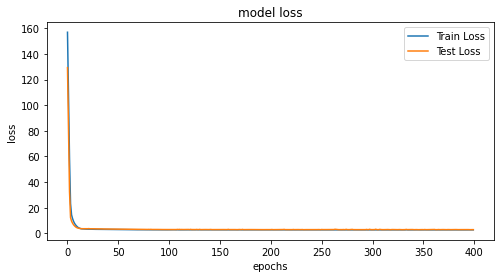

In [30]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [22]:
import seaborn as sns

In [23]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(2796,3174)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

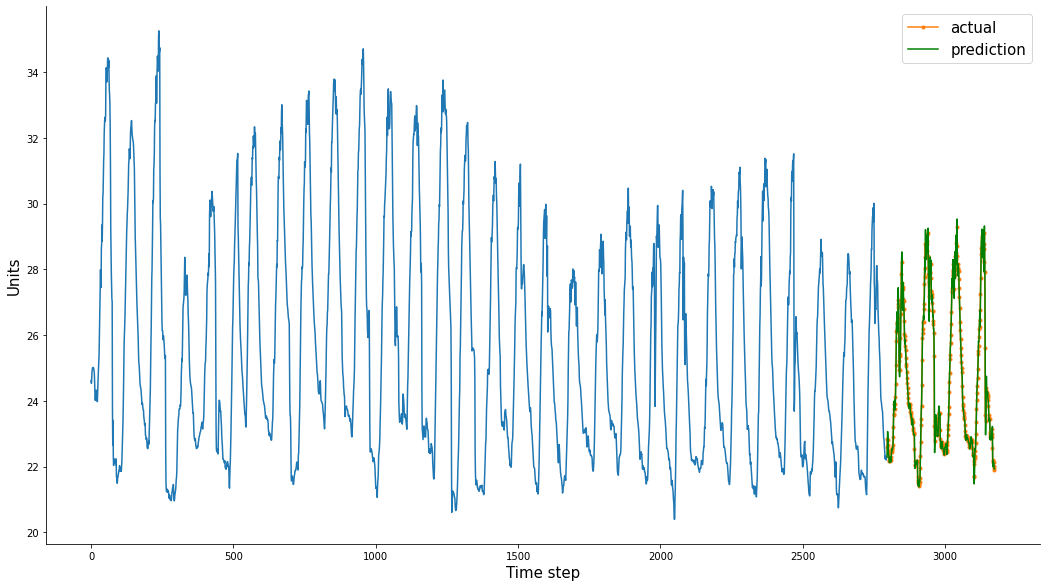

In [31]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)